In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import sys
sys.path.append('..')

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [2]:
from configs.seq_fd_gru import hparams
hparams = hparams()
print(hparams)

[('batch_size', 800), ('datagen', 'prodn'), ('in_seq_len', 168), ('input_channels', 1), ('input_dim', 5), ('lambd', 1e-06), ('learning_rate', 0.001), ('logs_path', '/tmp/tensorflow_logs'), ('lr_decay', 0.99), ('neurons_unit', 32), ('norm_epsilon', 1e-12), ('num_layers', 1), ('out_seq_len', 24), ('output_channels', 1), ('output_dim', 1), ('test_split', 0.1), ('train_split', 0.8), ('val_split', 0.1)]


In [39]:
hparams=tf.contrib.training.HParams(
        batch_size=800,
        in_seq_len=168,
        input_dim=5,
        input_channels=1,
        out_seq_len=24,
        output_dim=1,
        output_channels=1,
        num_layers=1,
        neurons_unit=32,
        learning_rate = 10 ** -3,
        lr_decay = 0.99,
        lambd = 1e-6,
        train_split = 0.8,
        val_split = 0.1,
        test_split = 0.1,
        norm_epsilon = 1e-12,
        datagen = 'prodn',
        logs_path = '/tmp/tensorflow_logs')

In [6]:
from data_loader.biogas import *
get_fields = 'AT305'
dataset, dataset_val, dataset_test = load_data(hparams, mode=get_fields)
_, (inp, target, mask, x_max) = enumerate(dataset).__next__()

In [401]:
class pAttention(tf.keras.Model):
    def __init__(self):
        super(pAttention, self).__init__()
        self.W1 = tf.Variable(2., 'W_separation')
        self.W2 = tf.Variable(1., 'W_scale')

    def cov(self, x):

        n_dim  = tf.cast(tf.shape(x)[1], tf.float32) - 1
        mu_x   = x - tf.reduce_mean(x, axis=1, keep_dims=True)
        cov_xx = tf.matmul(mu_x, mu_x, transpose_a=True) / n_dim
        
        return cov_xx
    
    def call(self, x, hidden):
        cov = self.cov(x)
        cov = tf.reduce_sum(cov, axis=1)
        score = tf.exp(self.W1) * cov / tf.reduce_max(cov, axis=1, keep_dims=True)
        weights = tf.nn.softmax(score, axis=1)
        weights = tf.expand_dims(weights, axis=1)
        
        outputs = self.W2 * tf.reduce_mean(weights * tf.squeeze(hidden), axis=-1, keepdims=True) 
        
        return outputs

In [19]:
class ConvRNN(tf.keras.Model):
    def __init__(self, input_dim, output_dim, in_seq_len, out_seq_len, neurons_unit, batch_size, name=None):
        super(ConvRNN, self).__init__()

        self.input_dim    = input_dim
        self.output_dim   = output_dim
        self.in_seq_len   = in_seq_len
        self.out_seq_len  = out_seq_len
        self.neurons_unit = neurons_unit
        self.batch_size   = batch_size
        
        self.cat = tf.keras.layers.Concatenate(axis=-1)

        self.conv1_2x1  = tf.keras.layers.Conv1D(16, 2, padding='valid', activation='tanh')
        self.conv1_3x1  = tf.keras.layers.Conv1D(8, 3, padding='valid', activation='tanh')
        self.conv1_5x1  = tf.keras.layers.Conv1D(8, 5,  padding='valid', activation='tanh')
        self.conv1_48x1 = tf.keras.layers.Conv1D(4, 48, padding='valid', activation='tanh')
        
        self.conv2_36x1 = tf.keras.layers.Conv2D(5, (1,36), padding='valid', activation='tanh')
        
        self.fc_out1    = tf.keras.layers.Dense(neurons_unit, activation='tanh')
        self.fc_out2    = tf.keras.layers.Dense(1, activation='linear')
        
    def reshape_deep(self, x):
        x = tf.reshape(x, [self.batch_size, self.input_dim, self.out_seq_len, -1])
        return tf.transpose(x, [0,2,1,3])
        
    def reshape_wide(self, x):
        x = tf.transpose(x, [0,2,1,3])
        return tf.reshape(x, [self.batch_size, self.input_dim * self.out_seq_len, -1])
    
    def encode(self, x):
        pos = self.out_seq_len * self.input_dim
        
        conv1_2x1  = self.conv1_2x1(x)
        conv1_3x1  = self.conv1_3x1(x)
        conv1_5x1  = self.conv1_5x1(x)
        conv1_48x1 = self.conv1_48x1(x)
        
        conv1 = self.cat([conv1_2x1[:,-pos:], conv1_3x1[:,-pos:],
                          conv1_5x1[:,-pos:], conv1_48x1[:,-pos:]])

        conv2 = self.conv2_36x1(tf.expand_dims(conv1,-1))
        conv2 = self.cat([x[:,-pos:], tf.squeeze(conv2)])

        return self.reshape_deep(conv2)

        
    def call(self, inp, mask):
        enc_out = self.encode(inp)
        x = tf.slice(inp, [0,inp.shape[1]-1,inp.shape[2]-1], [self.batch_size,1,1])

        fc1 = self.fc_out1(tf.reshape(enc_out, [self.batch_size, self.out_seq_len, -1]))
        fc2 = self.fc_out2(fc1)

        x = (x + fc2) * mask

        return x
    
    def _call_(self, inp, mask):
        enc_out = self.encode(inp)
        x = inp[:,-1]
        
        for t in range(self.out_seq_len):
            dec_in = tf.reshape(enc_out[:,t], [self.batch_size, -1])
            dec_in = self.cat([x, dec_in])

            fc1 = self.fc_out1(dec_in)
            fc2 = self.fc_out2(self.cat([x, fc1]))
            
            x = fc2 * mask[:,t]

            if t == 0:
                outputs = x
            else:
                outputs = tf.concat([outputs, x], axis=1)
        
        return tf.expand_dims(outputs,-1)

[<tf.Variable 'conv1d_60/kernel:0' shape=(2, 1, 1) dtype=float32, numpy=
array([[[-1.]],

       [[ 1.]]], dtype=float32)>]


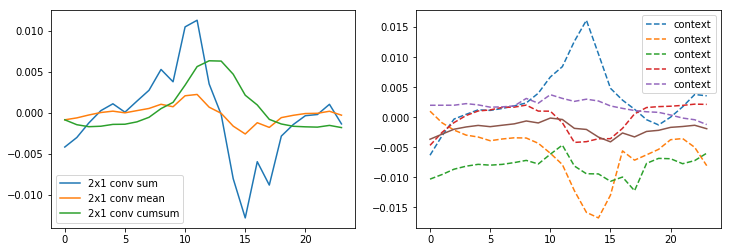

In [427]:
n = 24
pos = hparams.out_seq_len * hparams.input_dim
print(model.conv1_2x1.variables)

plt.plot(np.array(fcast[n]))
plt.plot(np.array(model.reshape_deep(inp[:,-pos:]))[n,:,:,0], '--')
plt.show()

plt.figure(figsize=(12,4))
ax = plt.subplot(1,2,1)
ax.plot(np.array(conv1[n]).sum(axis=(1)), label='2x1 conv sum')
ax.plot(np.array(conv1[n]).mean(axis=(1)), label='2x1 conv mean')
ax.plot(np.cumsum(conv1[n], axis=0).mean(axis=(1)), label='2x1 conv cumsum')
plt.legend()
ax = plt.subplot(1,2,2)
ax.plot(np.array(cox[n]), '--', label='context')
ax.plot(np.array(cox[n]).mean(axis=1))
plt.legend()
plt.show()

plt.plot(np.array(inp[n,-120:]))
plt.show()

## Train Model
loss_function: Build out MSE loss function with parameter regularisation

train_model: Runs the minibatch training loop

In [ ]:
import trainers.tf_eager_trainer as trainer

# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
model = MiniConvRNN(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
                hparams.neurons_unit, hparams.batch_size)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = trainer.train_model(model, optimizer, dataset, hparams,
                                                      epochs=20, verbose=True, dev_dataset=dataset_val)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 10000, accuracy * 10000, run_time))

plt.figure()
for name, stat in stats.items():
    if name != 'time':
        plt.plot(stat, label=name)
plt.legend()
plt.yscale('log')
plt.show()

model.summary()

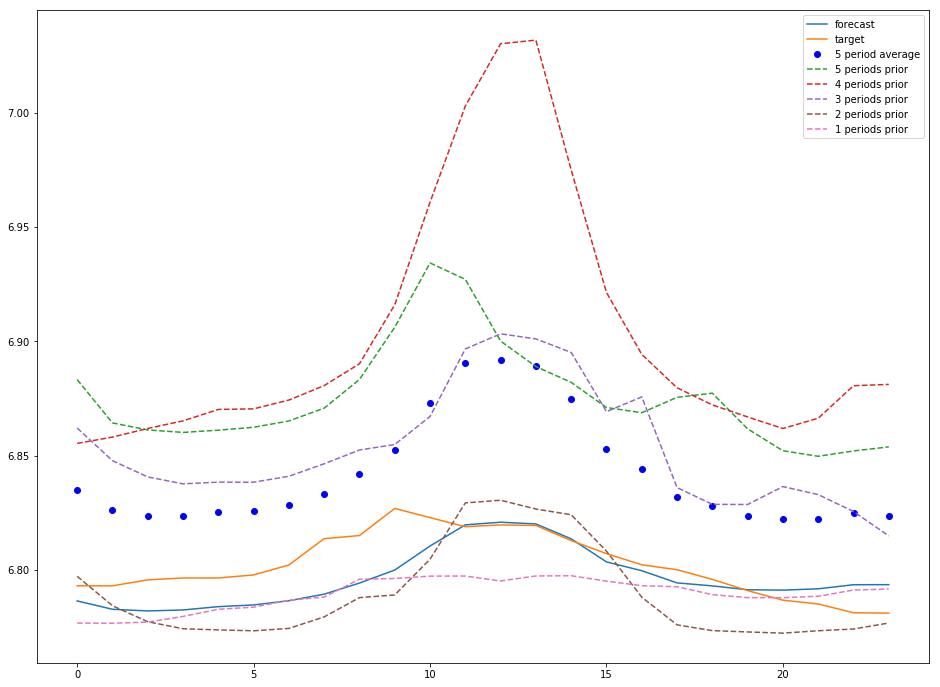

In [449]:
# show all sequences
# Select target sequence to show
TARGET_INDEX = 0

# Create forecast and rescale data
_, (inp, target, mask, x_max) = enumerate(dataset).__next__()
x_max = tf.expand_dims(x_max,-1)
forecast = model(inp, mask)
forecast *= x_max
target   *= x_max
inp      *= x_max
inp = tf.reshape(inp[:,-120:], [hparams.batch_size, hparams.input_dim, hparams.out_seq_len, -1])
inp = tf.transpose(inp, [0,2,1,3])

# Plot target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX,:,0]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX,:,0]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX,:,0], 'bo', label='5 period average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i,0], '--', label='%i periods prior' % (5-i))
plt.legend()
plt.show()

plt.figure(figsize=(16,16))
for i in range(0,800,8):
    ax = plt.subplot(10,10,i/8+1)
    ax.plot(np.squeeze(forecast[i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()

## Test Hyperparameters

In [152]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

inp, target, mask, x_max = next(iter(dataset))

#for lr in np.random.uniform(-8, -1, 10):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model = MiniConvRNN(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
                       hparams.neurons_unit, hparams.batch_size)
    conv1 = model.encode(inp)
    model.conv1_2x1.set_weights([np.array([[[-1.0]], [[ 1.0]]], dtype=np.float32),
                             np.array([0.], dtype=np.float32)])
    optimizer = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        trainer.train_model(model, optimizer, dataset, hparams, epochs = 50, verbose=False)
    print('Learning Rate {:.4f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(lr, loss*10000, accuracy * 10000, run_time))
    
    models.append(model)
    stats.append(stat)

Learning Rate -4.0000 Loss 0.0269 Accuracy 0.0269 Time 12.4
Learning Rate -3.5000 Loss 0.0268 Accuracy 0.0268 Time 12.3
Learning Rate -3.0000 Loss 0.0263 Accuracy 0.0263 Time 12.5
Learning Rate -2.5000 Loss 0.0264 Accuracy 0.0264 Time 13.4
Learning Rate -2.0000 Loss 0.0263 Accuracy 0.0263 Time 13.1
Learning Rate -1.5000 Loss 0.0253 Accuracy 0.0253 Time 13.0
Learning Rate -1.0000 Loss 0.0224 Accuracy 0.0224 Time 12.5
Learning Rate -0.5000 Loss 0.0196 Accuracy 0.0196 Time 14.4
